In [49]:
import os
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from tqdm import tqdm
import torch.nn.functional as F

class DIV2KPatchDataset(Dataset):
    def __init__(self, hr_dir, lr_dir, patch_size=33, scale=4):
        self.hr_files = sorted(glob.glob(os.path.join(hr_dir, "*.*")))
        self.lr_files = sorted(glob.glob(os.path.join(lr_dir, "*.*")))
        self.patch_size = patch_size
        self.scale = scale

    def __len__(self):
        return len(self.hr_files)

    def __getitem__(self, idx):
        hr_img = Image.open(self.hr_files[idx]).convert("RGB")
        lr_img = Image.open(self.lr_files[idx]).convert("RGB")

        hr_img = transforms.ToTensor()(hr_img)
        lr_img = transforms.ToTensor()(lr_img)

        _, h, w = lr_img.shape
        top = torch.randint(0, h - self.patch_size + 1, (1,)).item()
        left = torch.randint(0, w - self.patch_size + 1, (1,)).item()
        lr_patch = lr_img[:, top:top+self.patch_size, left:left+self.patch_size]
        hr_patch = hr_img[:, top*self.scale:(top+self.patch_size)*self.scale,
                          left*self.scale:(left+self.patch_size)*self.scale]
        lr_patch_up = F.interpolate(lr_patch.unsqueeze(0), scale_factor=self.scale, mode='bicubic', align_corners=False)
        lr_patch_up = lr_patch_up.squeeze(0)

        return lr_patch_up, hr_patch

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.layer1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.layer2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.layer3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

base_path = r"D:\DL Project"
train_hr = os.path.join(base_path, "DIV2K_train_HR")
train_lr = os.path.join(base_path, "DIV2K_train_LR_x4")
valid_hr = os.path.join(base_path, "DIV2K_valid_HR")
valid_lr = os.path.join(base_path, "DIV2K_valid_LR_x4")

batch_size = 4
lr = 1e-4
num_epochs = 20
patch_size = 33
scale = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_dataset = DIV2KPatchDataset(train_hr, train_lr, patch_size=patch_size, scale=scale)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = DIV2KPatchDataset(valid_hr, valid_lr, patch_size=patch_size, scale=scale)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

model = SRCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

def psnr(pred, target):
    mse = nn.functional.mse_loss(pred, target)
    return 10 * torch.log10(1 / mse)

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for lr_patches, hr_patches in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}"):
        lr_patches = lr_patches.to(device)
        hr_patches = hr_patches.to(device)

        optimizer.zero_grad()
        outputs = model(lr_patches)
        loss = criterion(outputs, hr_patches)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * lr_patches.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch}/{num_epochs}] Loss: {epoch_loss:.6f}")

    model.eval()
    psnr_total = 0.0
    with torch.no_grad():
        for lr_patches, hr_patches in valid_loader:
            lr_patches = lr_patches.to(device)
            hr_patches = hr_patches.to(device)
            outputs = model(lr_patches)
            psnr_total += psnr(outputs, hr_patches).item()
    avg_psnr = psnr_total / len(valid_loader)
    print(f"Validation PSNR: {avg_psnr:.2f} dB")
    torch.save(model.state_dict(), os.path.join(base_path, f"srcnn_epoch{epoch}.pth"))

print("✅ Training complete!")


Using device: cuda


Epoch 1/20: 100%|██████████| 200/200 [01:46<00:00,  1.88it/s]


Epoch [1/20] Loss: 0.108220
Validation PSNR: 12.46 dB


Epoch 2/20: 100%|██████████| 200/200 [01:43<00:00,  1.94it/s]


Epoch [2/20] Loss: 0.081745
Validation PSNR: 12.68 dB


Epoch 3/20: 100%|██████████| 200/200 [01:44<00:00,  1.91it/s]


Epoch [3/20] Loss: 0.077430
Validation PSNR: 12.30 dB


Epoch 4/20: 100%|██████████| 200/200 [01:46<00:00,  1.88it/s]


Epoch [4/20] Loss: 0.079353
Validation PSNR: 12.59 dB


Epoch 5/20: 100%|██████████| 200/200 [01:46<00:00,  1.88it/s]


Epoch [5/20] Loss: 0.076366
Validation PSNR: 12.89 dB


Epoch 6/20: 100%|██████████| 200/200 [01:47<00:00,  1.86it/s]


Epoch [6/20] Loss: 0.075684
Validation PSNR: 12.50 dB


Epoch 7/20: 100%|██████████| 200/200 [01:47<00:00,  1.85it/s]


Epoch [7/20] Loss: 0.074331
Validation PSNR: 12.72 dB


Epoch 8/20: 100%|██████████| 200/200 [01:47<00:00,  1.85it/s]


Epoch [8/20] Loss: 0.074763
Validation PSNR: 12.32 dB


Epoch 9/20: 100%|██████████| 200/200 [01:48<00:00,  1.85it/s]


Epoch [9/20] Loss: 0.076807
Validation PSNR: 12.49 dB


Epoch 10/20: 100%|██████████| 200/200 [01:48<00:00,  1.84it/s]


Epoch [10/20] Loss: 0.073672
Validation PSNR: 12.60 dB


Epoch 11/20: 100%|██████████| 200/200 [01:49<00:00,  1.83it/s]


Epoch [11/20] Loss: 0.074762
Validation PSNR: 12.62 dB


Epoch 12/20: 100%|██████████| 200/200 [01:48<00:00,  1.84it/s]


Epoch [12/20] Loss: 0.075262
Validation PSNR: 12.56 dB


Epoch 13/20: 100%|██████████| 200/200 [01:48<00:00,  1.84it/s]


Epoch [13/20] Loss: 0.075247
Validation PSNR: 12.71 dB


Epoch 14/20: 100%|██████████| 200/200 [01:49<00:00,  1.83it/s]


Epoch [14/20] Loss: 0.074651
Validation PSNR: 12.48 dB


Epoch 15/20: 100%|██████████| 200/200 [01:48<00:00,  1.84it/s]


Epoch [15/20] Loss: 0.073427
Validation PSNR: 13.11 dB


Epoch 16/20: 100%|██████████| 200/200 [01:49<00:00,  1.83it/s]


Epoch [16/20] Loss: 0.073203
Validation PSNR: 12.41 dB


Epoch 17/20: 100%|██████████| 200/200 [01:48<00:00,  1.84it/s]


Epoch [17/20] Loss: 0.076770
Validation PSNR: 12.60 dB


Epoch 18/20: 100%|██████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [18/20] Loss: 0.076865
Validation PSNR: 12.76 dB


Epoch 19/20: 100%|██████████| 200/200 [01:54<00:00,  1.75it/s]


Epoch [19/20] Loss: 0.076784
Validation PSNR: 12.10 dB


Epoch 20/20: 100%|██████████| 200/200 [01:48<00:00,  1.84it/s]


Epoch [20/20] Loss: 0.071240
Validation PSNR: 12.84 dB
✅ Training complete!


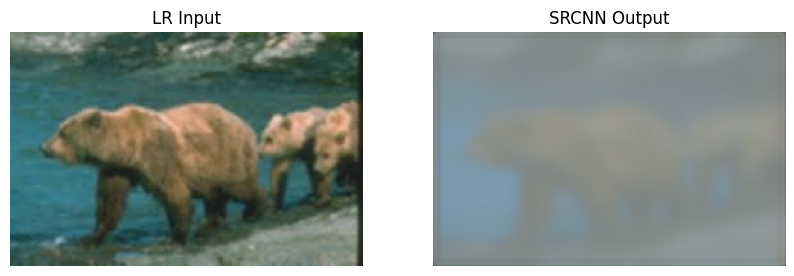

In [53]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn

# -----------------------------
# SRCNN Model
# -----------------------------
class SRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv2d(3, 64, 9, padding=4)
        self.layer2 = nn.Conv2d(64, 32, 1, padding=0)
        self.layer3 = nn.Conv2d(32, 3, 5, padding=2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# -----------------------------
# Device and Model Load
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SRCNN().to(device)
model.load_state_dict(torch.load(r"D:\DL Project\srcnn_epoch20.pth"))
model.eval()

# -----------------------------
# Load LR image
# -----------------------------
image_path = r"D:\DL Project\image4.png"
lr_img = Image.open(image_path).convert("RGB")

to_tensor = transforms.ToTensor()
lr_tensor = to_tensor(lr_img).unsqueeze(0).to(device)  # add batch dimension

# -----------------------------
# Iterative SRCNN passes
# -----------------------------
num_iterations = 2  # number of times to apply SRCNN
sr_tensor = lr_tensor.clone()

with torch.no_grad():
    for i in range(num_iterations):
        sr_tensor = model(sr_tensor)

# -----------------------------
# Convert to PIL for display
# -----------------------------
to_pil = transforms.ToPILImage()
sr_img = to_pil(sr_tensor.squeeze(0).cpu().clamp(0, 1))

# -----------------------------
# Display results
# -----------------------------
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("LR Input")
plt.imshow(lr_img)
plt.axis("off")

plt.subplot(1,2,2)
plt.title(f"SRCNN Output")
plt.imshow(sr_img)
plt.axis("off")
plt.show()
